In [3]:
# Install required libraries
!pip install scikit-learn-intelex
!pip install xgboost
import sklearn
from sklearnex import patch_sklearn
patch_sklearn()
#unpatch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas import MultiIndex, Int16Dtype # if you don't import in this order you will get a pandas.Int64Index fix for FutureWarning error.
import xgboost as xgb
import numpy as np
from time import perf_counter
print("XGB Version          : ", xgb.__version__)
print("Scikit-Learn Version : ", sklearn.__version__)
print("Pandas Version       : ", pd.__version__)

XGB Version          :  2.1.3
Scikit-Learn Version :  1.5.1
Pandas Version       :  2.2.2


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
filename = "data90.csv"
names =  ['time', 'lat','lon','sea_surface_temperature']
#data = pd.read_csv(filename, names=names, delimiter=",", nrows=100000)
data = pd.read_csv(filename, names=names, delimiter=",", nrows=1100000)
print(data.shape)

(100000, 4)


In [7]:
data.head()

,time,lat,lon,sea_surface_temperature
0,time,lat,lon,sea_surface_temperature
1,2024-11-29T05:00:00Z,-59.975,67.975,272.22
2,2024-11-29T05:00:00Z,-59.975,68.025,272.18
3,2024-11-29T05:00:00Z,-59.975,68.075,272.01
4,2024-11-29T05:00:00Z,-59.975,68.125,272.01


In [9]:
data.dtypes

time                       object
lat                        object
lon                        object
sea_surface_temperature    object
dtype: object

In [11]:
# Count values for the 'category' column
if 'time' in data.columns:
    print("Value counts for 'time':")
    print(data['time'].value_counts())
else:
    print("Column 'time' not found!")

# Count values for the 'sub_category' column
if 'lat' in data.columns:
    print("\nValue counts for 'lat':")
    print(data['lat'].value_counts())
else:
    print("Column 'lat' not found!")

if 'lon' in data.columns:
    print("Value counts for 'lon':")
    print(data['lon'].value_counts())
else:
    print("Column 'lon' not found!")

if 'sea_surface_temperature' in data.columns:
    print("Value counts for 'sea_surface_temperature':")
    print(data['sea_surface_temperature'].value_counts())
else:
    print("Column 'sea_surface_temperature' not found!")


Value counts for 'time':
time
2024-11-29T05:00:00Z    99999
time                        1
Name: count, dtype: int64

Value counts for 'lat':
lat
-34.575    957
-34.425    941
-34.675    922
-34.625    920
-34.525    919
          ... 
-58.775      3
-58.725      3
-58.625      2
-58.675      1
lat          1
Name: count, Length: 530, dtype: int64
Value counts for 'lon':
lon
-0.725     170
-0.775     170
-0.375     169
-0.675     169
-0.825     167
          ... 
100.825      1
48.975       1
48.925       1
-12.525      1
100.975      1
Name: count, Length: 2293, dtype: int64
Value counts for 'sea_surface_temperature':
sea_surface_temperature
292.87    182
292.92    178
293.05    178
292.76    177
292.75    176
         ... 
298.01      1
297.84      1
297.93      1
297.79      1
297.92      1
Name: count, Length: 2730, dtype: int64


In [13]:
X, y= data.iloc[:, 1:],data.iloc[:,0]


In [15]:
print(data.iloc[:,1:])

           lat     lon  sea_surface_temperature
0          lat     lon  sea_surface_temperature
1      -59.975  67.975                   272.22
2      -59.975  68.025                   272.18
3      -59.975  68.075                   272.01
4      -59.975  68.125                   272.01
...        ...     ...                      ...
99995  -33.575  14.075                    290.4
99996  -33.575  14.125                   290.49
99997  -33.575  14.175                   290.29
99998  -33.575  14.225                   290.34
99999  -33.575  14.275                   290.06

[100000 rows x 3 columns]


In [17]:
print(data.iloc[:,0])

0                        time
1        2024-11-29T05:00:00Z
2        2024-11-29T05:00:00Z
3        2024-11-29T05:00:00Z
4        2024-11-29T05:00:00Z
                 ...         
99995    2024-11-29T05:00:00Z
99996    2024-11-29T05:00:00Z
99997    2024-11-29T05:00:00Z
99998    2024-11-29T05:00:00Z
99999    2024-11-29T05:00:00Z
Name: time, Length: 100000, dtype: object


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Assuming a 80/20 train/test split

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from time import perf_counter
import warnings

# ... (your existing code to load and prepare data) ...

# Convert y_train to numeric if it contains strings
if y_train.dtype == object: # Check if the dtype is 'object', which usually indicates strings
    y_train = pd.to_numeric(y_train, errors='coerce')  # Convert to numeric, replace invalid values with NaN
    # Convert y_train to a Pandas Series to use fillna()
    y_train = pd.Series(y_train)
    y_train = y_train.fillna(0).astype(int) # Fill NaNs with 0 and convert to integer
    # Convert y_train back to a NumPy array if needed
    y_train = y_train.to_numpy()

# Convert problematic columns in X_train to numeric
for col in ['lat', 'lon', 'sea_surface_temperature']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# Set XGBoost parameters
xgb_params = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
}

# Train the model
warnings.simplefilter(action='ignore', category=UserWarning)
t1_start = perf_counter()  # Time fit function
model_xgb= xgb.XGBClassifier(**xgb_params)
model_xgb.fit(X_train,y_train)
t1_stop = perf_counter()
print ("It took", t1_stop-t1_start," to fit.")

It took 2.101413799999932  to fit.


In [22]:
# Convert problematic columns in X_test to numeric before prediction
for col in ['lat', 'lon', 'sea_surface_temperature']:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

result_predict_xgb_test = model_xgb.predict(X_test)

In [25]:
# Check model accuracy
# Convert problematic columns in X_test to numeric before prediction
for col in ['lat', 'lon', 'sea_surface_temperature']:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
acc = np.mean(y_test == result_predict_xgb_test)
print("Model accuracy =",acc)

Model accuracy = 0.0


In [27]:
# Convert problematic columns in X_test to numeric before prediction
for col in ['lat', 'lon', 'sea_surface_temperature']:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')
    param_grid = {
    "learning_rate": [0.1, 0.3, 0.5],
    "gamma": [0, 0.25, 1],
    "max_depth": [4, 6, 8],
    "subsample": [0.5, 1],
    "colsample_bytree": [0.7, 1],
    "colsample_bynode": [0.7, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1],
}

In [29]:
from sklearn.model_selection import GridSearchCV
xgb_params2 = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
    'tree_method':                  'hist',
}
# Necessary for now to supress multi-threaded Future errors with respect to pandas and XGBoost
import os
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

# Train the model
model_xgb= xgb.XGBClassifier(**xgb_params2, use_label_encoder=False)

# Setup grid search n_jobs=-1 uses all cores, reducing cv from 5 to 3 for speed, scoring is done using area under curve.
grid_cv = GridSearchCV(model_xgb, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")

# This fit function takes a while--hours, make sure you are ready.
_ = grid_cv.fit(X_train, y_train)

In [31]:
grid_cv.best_score_

nan

In [33]:
grid_cv.best_params_

{'colsample_bynode': 0.7,
 'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.5}

In [35]:
# Datasets used for evaluation after each round
evalset = [(X_train, y_train), (X_test,y_test)]

In [37]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Sample data creation (replace this with your actual data)
# Assuming 'y' contains datetime strings or similar values
X = pd.DataFrame(np.random.randint(0, 100, size=(100, 4)), columns=['col1', 'col2', 'col3', 'col4'])
y = np.random.choice(['2024-11-27T10:00:00Z', 'time'], size=100)

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # This will convert string labels to integers

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize XGBClassifier
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Fit the model with eval_set for monitoring performance
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Make predictions on validation set
y_pred = model.predict(X_val)

# Calculate accuracy or other metrics as needed
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

[0]	validation_0-logloss:0.74974
[1]	validation_0-logloss:0.77874
[2]	validation_0-logloss:0.81155
[3]	validation_0-logloss:0.84912
[4]	validation_0-logloss:0.84445
[5]	validation_0-logloss:0.89311
[6]	validation_0-logloss:0.90834
[7]	validation_0-logloss:0.95223
[8]	validation_0-logloss:0.99521
[9]	validation_0-logloss:1.01002
[10]	validation_0-logloss:1.04471
[11]	validation_0-logloss:1.06823
[12]	validation_0-logloss:1.11625
[13]	validation_0-logloss:1.12623
[14]	validation_0-logloss:1.14963
[15]	validation_0-logloss:1.17435
[16]	validation_0-logloss:1.21256
[17]	validation_0-logloss:1.23196
[18]	validation_0-logloss:1.23408
[19]	validation_0-logloss:1.25465
[20]	validation_0-logloss:1.29534
[21]	validation_0-logloss:1.30319
[22]	validation_0-logloss:1.31555
[23]	validation_0-logloss:1.31701
[24]	validation_0-logloss:1.32792
[25]	validation_0-logloss:1.35356
[26]	validation_0-logloss:1.36842
[27]	validation_0-logloss:1.37401
[28]	validation_0-logloss:1.39772
[29]	validation_0-loglos

In [39]:
# Set XGBoost parameters
xgb_params = {
    'objective':                    'binary:logistic',
    'predictor':                    'cpu_predictor',
    'disable_default_eval_metric':  'true',
    'max_depth':                     8,
    'learning_rate':                 0.1,
    'subsample':                     1,
    'gamma':                         0,
    'reg_lambda':                    10,
    'scale_pos_weight':              1,
    'tree_method':                  'hist', 
    'n_estimators':                  1000,
}

# Train the model
t1_start = perf_counter()  # Time fit function
model_xgb= xgb.XGBClassifier(**xgb_params)
# Call the fit method to train the model
model_xgb.fit(X_train, y_train) # This line is added to fit the model
t1_stop = perf_counter()
print ("It took", t1_stop-t1_start,"seconds to fit.")

It took 0.9784818999999061 seconds to fit.


In [41]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Sample data creation (replace this with your actual data)
# Assuming X and y are your features and labels
X = pd.DataFrame(np.random.randint(0, 100, size=(100, 3)), columns=['lat', 'lon', 'sea_surface_temperature'])
y = np.random.choice(['class_0', 'class_1'], size=100)

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize XGBClassifier
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Prepare X_test with matching feature names and order
X_test = pd.DataFrame(np.random.randint(0, 100, size=(20, 3)), columns=['lat', 'lon', 'sea_surface_temperature'])

# Make predictions on test set
result_predict_xgb_test = model.predict(X_test)

# Calculate accuracy (assuming you have y_test)
y_test = np.random.choice(['class_0', 'class_1'], size=20)  # Replace with actual test labels if available
y_test_encoded = encoder.transform(y_test)  # Encode y_test similarly

acc = np.mean(y_test_encoded == result_predict_xgb_test)
print("Model accuracy =", acc)

Model accuracy = 0.5


In [43]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sample data creation (replace this with your actual data)
X = np.random.rand(100, 4)  # Example feature set
y = np.random.choice(['class_0', 'class_1'], size=100)  # Example labels

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize XGBClassifier
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Define eval_set for monitoring performance
eval_set = [(X_val, y_val)]

# Fit the model with eval_set
model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Retrieve evaluation results
results = model.evals_result()

# Print evaluation results
print("Evaluation results:", results)

[0]	validation_0-logloss:0.68202
[1]	validation_0-logloss:0.69381
[2]	validation_0-logloss:0.70457
[3]	validation_0-logloss:0.74564
[4]	validation_0-logloss:0.74835
[5]	validation_0-logloss:0.75101
[6]	validation_0-logloss:0.77875
[7]	validation_0-logloss:0.74743
[8]	validation_0-logloss:0.77713
[9]	validation_0-logloss:0.77083
[10]	validation_0-logloss:0.77216
[11]	validation_0-logloss:0.76510
[12]	validation_0-logloss:0.78438
[13]	validation_0-logloss:0.79562
[14]	validation_0-logloss:0.79948
[15]	validation_0-logloss:0.78600
[16]	validation_0-logloss:0.80592
[17]	validation_0-logloss:0.81062
[18]	validation_0-logloss:0.80869
[19]	validation_0-logloss:0.80569
[20]	validation_0-logloss:0.81365
[21]	validation_0-logloss:0.81526
[22]	validation_0-logloss:0.80913
[23]	validation_0-logloss:0.82598
[24]	validation_0-logloss:0.84199
[25]	validation_0-logloss:0.84764
[26]	validation_0-logloss:0.85464
[27]	validation_0-logloss:0.84941
[28]	validation_0-logloss:0.86358
[29]	validation_0-loglos

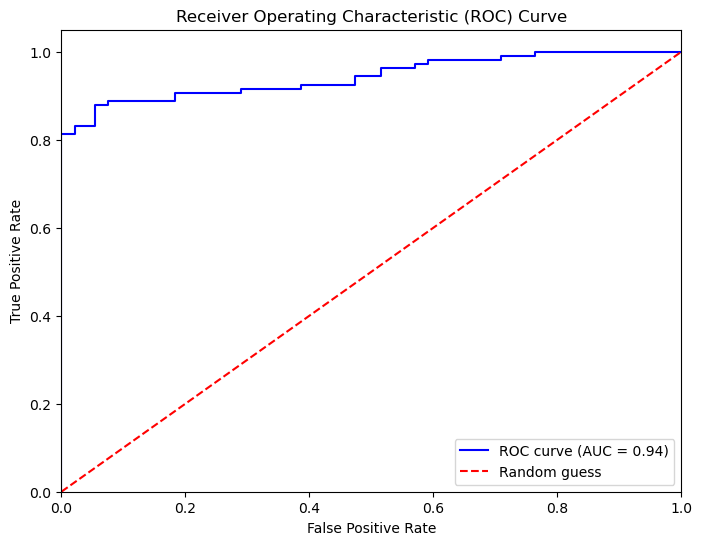

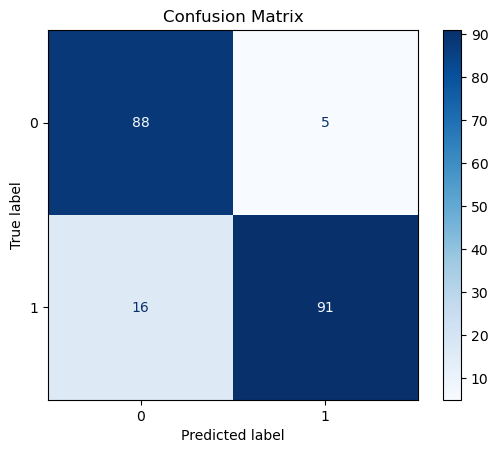

Accuracy: 0.90


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make probability predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate confusion matrix and accuracy
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")

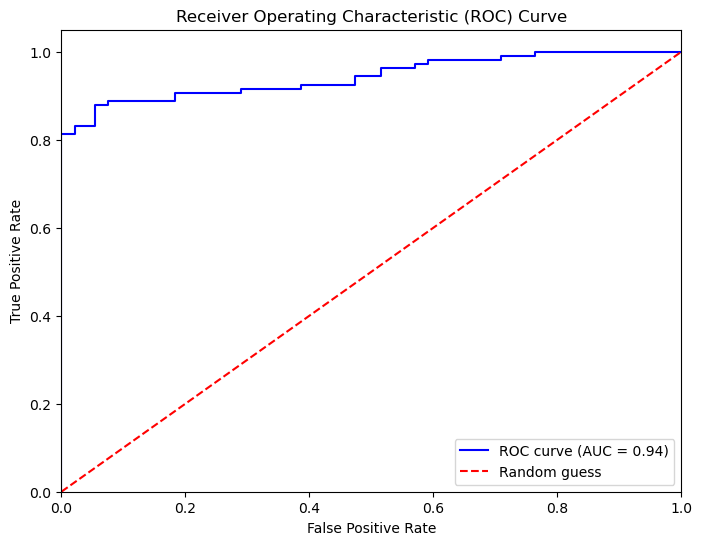

Accuracy: 0.895


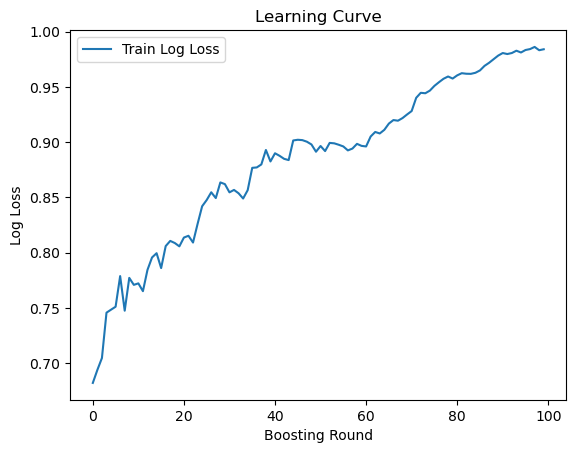

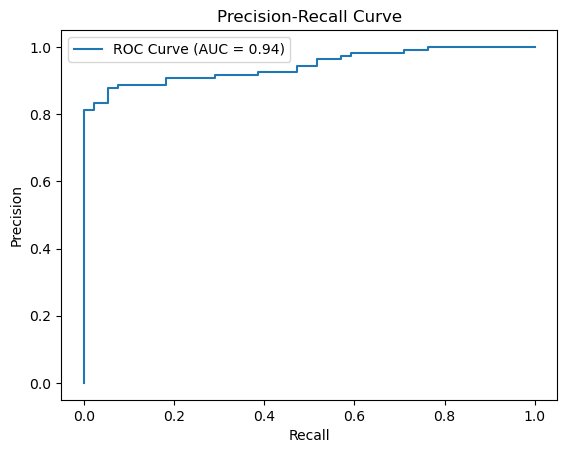

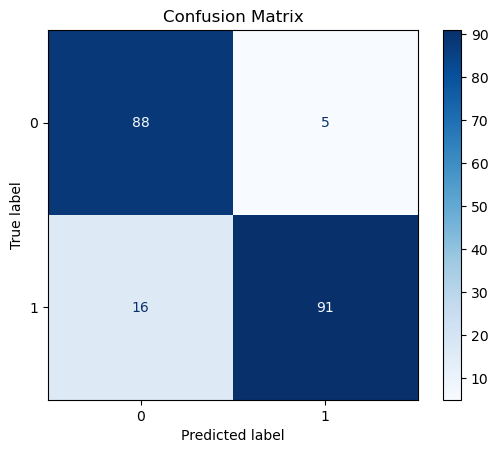

Accuracy: 0.90


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Generate a synthetic dataset for binary classification
X, y = make_classification(n_samples=1000, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make probability predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Calculate confusion matrix and accuracy
# Print evaluation metrics
print("Accuracy:", accuracy)

# Plot Log Loss for training and validation
plt.plot(results['validation_0']['logloss'], label='Train Log Loss')
plt.xlabel('Boosting Round')
plt.ylabel('Log Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Plot ROC Curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt
# Plot Precision-Recall Curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print accuracy
print(f"Accuracy: {accuracy:.2f}")